**Guy Yutal - 308013861**

**Matan Leventer - 208447029**

#Imports

In [ ]:
# !pip install tmdbv3api
!pip install kaggle
# !pip install datasets
# !pip install wikipedia
# !pip install networkx
# !pip install vaex
!pip install plotly-geo
!pip install geopandas
# !pip install openalexapi
# !pip install pyshp
# !pip install shapely
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 50.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 6.6 MB/s eta 0:00:00


In [ ]:
import json
import os
import sqlite3
import pandas as pd
# import vaex
from pathlib import Path
# from datasets import load_dataset
import matplotlib
import timeit
import numpy as np
import datetime
import requests
from bs4 import BeautifulSoup
# from tmdbv3api import TMDb,Movie, Keyword
import networkx as nx
import seaborn as sns
import pyarrow as pa
import matplotlib.pyplot as plt
import plotly.express as px
import spacy
from tqdm import tqdm
import en_core_web_sm
import geopy
import geopandas
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import shap

# from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
%matplotlib inline

#Data Loading

In [ ]:
# Read all sheets into a dictionary of DataFrames
# The keys of the dictionary will be the sheet names, and the values will be DataFrames
raw_observes_df = pd.read_excel("/content/maarag_acacias_fulcrum 2016-2021.xlsx", sheet_name="maarag_acacias_acacia_observati")
raw_plot_df = pd.read_excel("/content/maarag_acacias_fulcrum 2016-2021.xlsx", sheet_name="maarag_acacias (2)")
raw_plot_df = raw_plot_df.dropna(subset=['tree_id'])

def convert_tree(tree_id):
    try:
        return int(tree_id)
    except:
        return -1  # Replace non-convertible values with -1, or use another suitable marker

raw_plot_df['tree_id'] = raw_plot_df['tree_id'].apply(convert_tree)

PlotByNum = pd.read_csv('/content/PlotByNum.csv')
PlotByNum.rename(columns={'Tree_ID': 'tree_id'}, inplace=True)
# PlotByNum['tree_id'] = PlotByNum['tree_id'].astype(str)

Site_data = pd.read_excel('/content/Site_data.xlsx')
Site_data.rename(columns={'site_val': 'site_new'}, inplace=True)

##MetaData

###Raw_Observations

In [ ]:
raw_observes_df.shape

(8930, 62)

In [ ]:
raw_observes_df.columns

Index(['_child_record_id', '_record_id', '_parent_id', '_record_status',
       '_title', '_version', '_created_at', '_updated_at', '_record_project',
       '_record_assigned_to', '_created_by', '_updated_by', '_index',
       '_geometry', '_latitude', '_longitude', '_changeset_id',
       '_created_duration', '_updated_duration', '_edited_duration',
       'site_val', 'tree_id_val', 'specie_val', 'stream_val', 'date', 'time',
       'monitors', 'cloud_cover', 'foliage', 'flowers', 'pods',
       'pods_on_ground_0_3', 'pelicosepalus_acaciae', 'ndvi_calibration',
       'ndvi_picture', 'rgb_picture', 'ndvi_calibration_int',
       'ndvi_picture_int', 'rgb_picture_int', 'photos', 'photos_captions',
       'photos_urls', 'browsing', 'lowest_leaf_s_cm', 'browsing_height_s',
       'lowest_leaf_e_cm', 'browsing_height_e', 'lowest_leaf_n_cm',
       'browsing_height_n', 'lowest_leaf_w_cm', 'browsing_height_w',
       'dendrometer', 'perimeter_cm', 'seedling', 'uninfected_pods', 'out_of',
  

In [ ]:
# Check for missing values in each column
raw_observes_df.isnull().sum()

_child_record_id        0
_record_id              0
_parent_id              0
_record_status          0
_title                762
                     ... 
canopy_n_s_cm        7008
canopy_e_w_cm        6457
new_perimeter_cm     8883
remarks              7500
geography_remarks    8834
Length: 62, dtype: int64

In [ ]:
# Get an overview of the DataFrame's columns, data types, and non-null values
raw_observes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8930 entries, 0 to 8929
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _child_record_id       8930 non-null   object 
 1   _record_id             8930 non-null   object 
 2   _parent_id             8930 non-null   object 
 3   _record_status         8930 non-null   object 
 4   _title                 8168 non-null   object 
 5   _version               8930 non-null   int64  
 6   _created_at            8930 non-null   object 
 7   _updated_at            8930 non-null   object 
 8   _record_project        860 non-null    object 
 9   _record_assigned_to    0 non-null      float64
 10  _created_by            8930 non-null   object 
 11  _updated_by            8930 non-null   object 
 12  _index                 8930 non-null   int64  
 13  _geometry              7772 non-null   object 
 14  _latitude              7772 non-null   float64
 15  _lon

In [ ]:
# Get summary statistics for numeric columns
raw_observes_df.describe()

,_version,_record_assigned_to,_index,_latitude,_longitude,_created_duration,_updated_duration,_edited_duration,cloud_cover,foliage,...,browsing_height_w,dendrometer,perimeter_cm,seedling,uninfected_pods,out_of,height,canopy_n_s_cm,canopy_e_w_cm,new_perimeter_cm
count,8930.000000,0.0,8930.000000,7772.000000,7772.000000,8204.000000,8205.000000,8205.000000,919.000000,5987.000000,...,3270.000000,285.000000,5810.000000,327.000000,157.000000,7220.000000,2346.000000,1922.000000,2473.000000,47.000000
mean,3.053639,NaN,30.918029,30.241865,35.106596,115.903584,96.600244,137.788787,7.036997,2.956740,...,723.676147,27.278246,45.161132,0.648318,6.636943,50.004155,348.356053,645.170187,843.539385,60.526809
std,1.778888,NaN,115.091353,0.431035,0.112561,228.146018,405.451531,448.977117,1.456988,1.128689,...,3976.300425,42.746473,34.415328,5.611272,5.479745,5.512919,250.091865,414.240171,8052.044444,153.484228
min,1.000000,NaN,0.000000,29.540338,34.889034,1.000000,1.000000,3.000000,0.000000,0.000000,...,0.000000,-6.000000,0.000000,0.000000,0.000000,10.000000,2.600000,3.500000,1.400000,0.000000
25%,1.000000,NaN,0.000000,30.015109,35.051843,35.000000,21.000000,43.000000,7.000000,2.000000,...,90.000000,7.500000,22.000000,0.000000,2.000000,50.000000,220.000000,360.000000,380.000000,9.000000
50%,3.000000,NaN,1.000000,30.142883,35.119092,87.000000,57.000000,104.000000,8.000000,3.000000,...,130.000000,20.000000,36.000000,0.000000,6.000000,50.000000,320.000000,580.000000,600.000000,22.200000
75%,4.000000,NaN,4.000000,30.721505,35.187903,160.250000,134.000000,183.000000,8.000000,4.000000,...,170.000000,35.500000,57.500000,0.000000,10.000000,50.000000,460.000000,870.000000,860.000000,43.050000
max,14.000000,NaN,724.000000,32.904379,35.416384,16093.000000,34655.000000,34802.000000,8.000000,5.000000,...,99999.000000,615.000000,246.000000,80.000000,24.000000,503.000000,4700.000000,7080.000000,396514.000000,950.000000


######Raw_Plot

In [ ]:
raw_plot_df.shape

(8609, 45)

In [ ]:
raw_plot_df.columns

Index(['_record_id', '_status', '_title', '_server_updated_at', '_project',
       '_assigned_to', '_updated_by', '_geometry', '_latitude', '_longitude',
       'site', 'site_new', 'tree_id', 'sp', 'species', 'stream',
       'plot_orientation', 'current_status', 'dimensions', 'floods', 'flood_1',
       'flood_2', 'flood_3', 'flood_4', 'flood_5', 'tree_remarks',
       'germ_observations', 'acacia_observations', 'tree_id_val', 'monitors',
       'foliage', 'flowers', 'pods', 'pelicosepalus_acaciae', 'browsing',
       'lowest_leaf_s_cm', 'browsing_height_s', 'dendrometer', 'perimeter_cm',
       'height', 'canopy_n_s_cm', 'canopy_e_w_cm', 'new_perimeter_cm',
       'remarks', 'geography_remarks'],
      dtype='object')

In [ ]:
# Check for missing values in each column
raw_plot_df.isnull().sum()

_record_id                  0
_status                     0
_title                      0
_server_updated_at          0
_project                 7709
_assigned_to             8609
_updated_by                 0
_geometry                   0
_latitude                   0
_longitude                  0
site                     2332
site_new                   50
tree_id                     0
sp                       2222
species                   161
stream                   4438
plot_orientation         7507
current_status            408
dimensions               8450
floods                   3966
flood_1                  8609
flood_2                  8609
flood_3                  8609
flood_4                  8609
flood_5                  8609
tree_remarks             7804
germ_observations        8579
acacia_observations       417
tree_id_val              1563
monitors                  876
foliage                  2626
flowers                  2857
pods                     3057
pelicosepa

In [ ]:
# Get an overview of the DataFrame's columns, data types, and non-null values
raw_plot_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8609 entries, 0 to 9400
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _record_id             8609 non-null   object 
 1   _status                8609 non-null   object 
 2   _title                 8609 non-null   object 
 3   _server_updated_at     8609 non-null   object 
 4   _project               900 non-null    object 
 5   _assigned_to           0 non-null      float64
 6   _updated_by            8609 non-null   object 
 7   _geometry              8609 non-null   object 
 8   _latitude              8609 non-null   float64
 9   _longitude             8609 non-null   float64
 10  site                   6277 non-null   object 
 11  site_new               8559 non-null   object 
 12  tree_id                8609 non-null   int64  
 13  sp                     6387 non-null   object 
 14  species                8448 non-null   object 
 15  stre

In [ ]:
# Get summary statistics for numeric columns
raw_plot_df.describe()

,_assigned_to,_latitude,_longitude,tree_id,flood_1,flood_2,flood_3,flood_4,flood_5,germ_observations,...,pods,pelicosepalus_acaciae,lowest_leaf_s_cm,browsing_height_s,dendrometer,perimeter_cm,height,canopy_n_s_cm,canopy_e_w_cm,new_perimeter_cm
count,0.0,8609.000000,8609.000000,8609.000000,0.0,0.0,0.0,0.0,0.0,30.000000,...,5552.000000,3990.000000,2192.000000,3904.000000,285.000000,5807.000000,2343.000000,1922.000000,2471.000000,47.000000
mean,NaN,30.309610,35.118461,712.966547,NaN,NaN,NaN,NaN,NaN,1.400000,...,0.325108,6.711028,394.390055,379.065574,27.278246,45.181029,348.746479,645.170656,844.129098,60.526809
std,NaN,0.446463,0.126491,969.449151,NaN,NaN,NaN,NaN,NaN,0.498273,...,0.902785,158.796130,3896.835775,2658.191452,42.746473,34.412921,250.013236,414.240009,8055.276254,153.484228
min,NaN,29.540477,34.883987,-1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,...,0.000000,0.000000,0.000000,-106.000000,-6.000000,0.000000,3.000000,4.000000,1.000000,0.000000
25%,NaN,30.139496,35.047225,44.000000,NaN,NaN,NaN,NaN,NaN,1.000000,...,0.000000,0.000000,1.000000,80.000000,7.500000,22.000000,220.000000,360.000000,380.000000,9.000000
50%,NaN,30.144563,35.128459,321.000000,NaN,NaN,NaN,NaN,NaN,1.000000,...,0.000000,0.000000,55.000000,110.000000,20.000000,36.000000,320.000000,580.000000,600.000000,22.200000
75%,NaN,30.730498,35.226040,885.000000,NaN,NaN,NaN,NaN,NaN,2.000000,...,0.000000,0.000000,100.000000,140.000000,35.500000,57.500000,460.000000,870.000000,862.500000,43.050000
max,NaN,31.354300,35.395647,4321.000000,NaN,NaN,NaN,NaN,NaN,2.000000,...,5.000000,9999.000000,99999.000000,99999.000000,615.000000,246.000000,4700.000000,7080.000000,396514.000000,950.000000


#Data Cleaning & PreProcessing

##Raw_Obs

In [ ]:
col_to_keep_obs = ['_record_id', 'stream_val', 'date','monitors','foliage', 'flowers', 'pods',
        'pelicosepalus_acaciae', 'browsing_height_s','perimeter_cm','height', 'canopy_e_w_cm']
raw_observes_df = raw_observes_df[col_to_keep_obs]
raw_observes_df = raw_observes_df.dropna(subset=['date'])

##Raw_plot

In [ ]:
col_to_keep_plot = ['_record_id','_geometry', '_latitude', '_longitude', 'site_new', 'tree_id','species', 'stream',
       'current_status','monitors', 'foliage', 'flowers', 'pods', 'browsing_height_s', 'perimeter_cm','height', 'canopy_e_w_cm']
raw_plot_df = raw_plot_df[col_to_keep_plot]
raw_plot_df = raw_plot_df[raw_plot_df['site_new'] != 'Shita LTER']
raw_plot_df = raw_plot_df[raw_plot_df['tree_id'] < 2000]
raw_plot_df = raw_plot_df[raw_plot_df['tree_id'] > 0]

##Preprocess

In [ ]:
# Perform the left join
merged_row_df = pd.merge(raw_plot_df, raw_observes_df, on=['_record_id','monitors', 'foliage', 'flowers', 'pods','perimeter_cm','height','canopy_e_w_cm','browsing_height_s'], how='left')
merged_row_df['date'] = pd.to_datetime(merged_row_df['date'])
merged_row_df['year'] = merged_row_df['date'].dt.year
merged_row_df['month'] = merged_row_df['date'].dt.month
merged_row_df['day'] = merged_row_df['date'].dt.day

In [ ]:
merged_row_df = merged_row_df.drop_duplicates()
merged_df = merged_row_df.merge(PlotByNum, on='tree_id', how='left')
merged_df = merged_df.merge(Site_data, on='site_new', how='left')

#Plots

## Distrbution plot

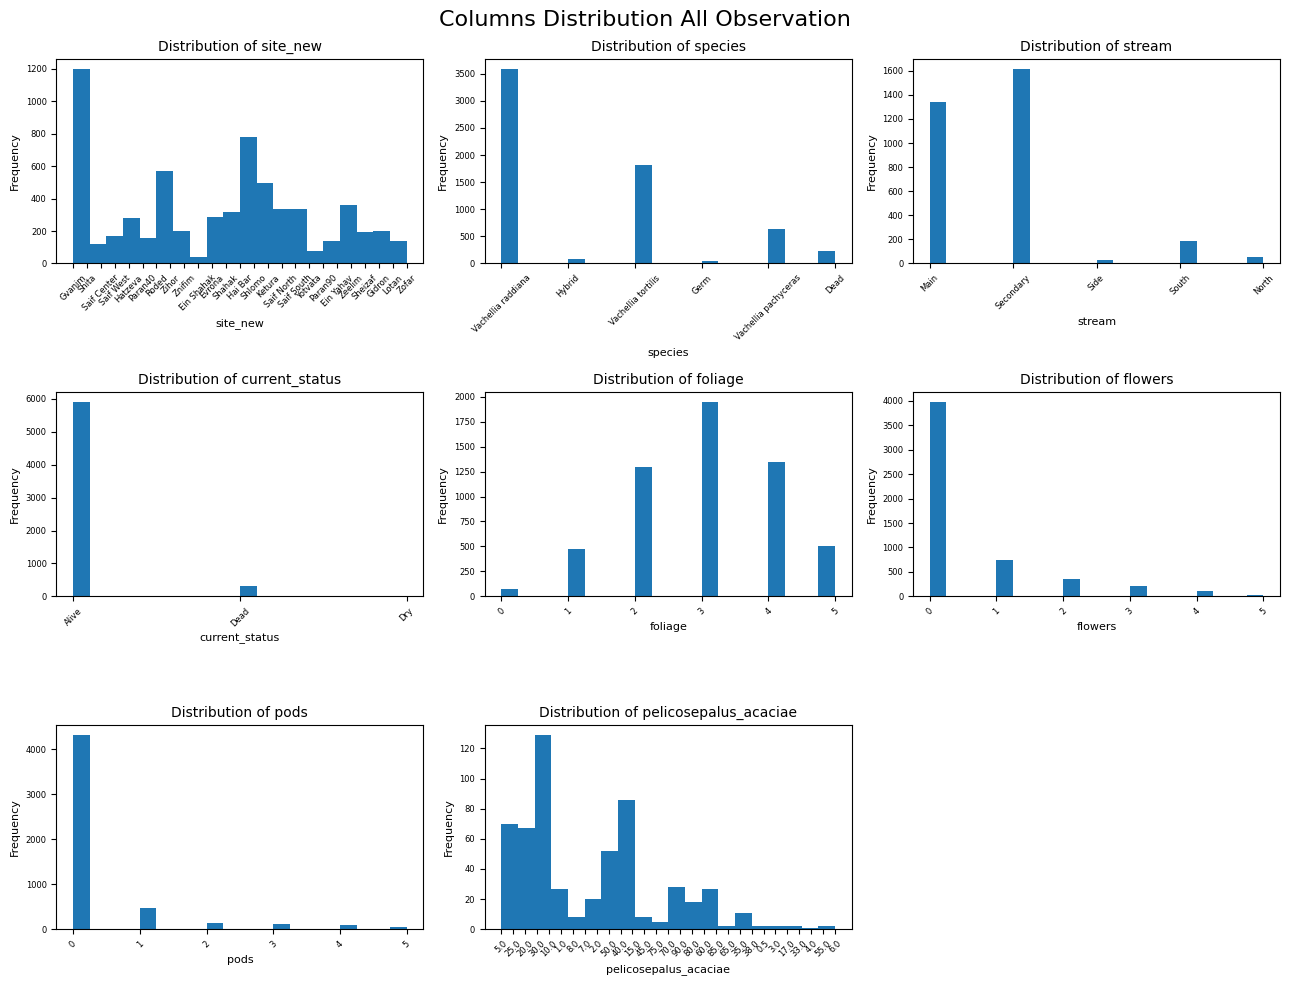

In [ ]:
lst_to_check = ['site_new','species', 'stream', 'current_status', 'foliage','flowers', 'pods', 'pelicosepalus_acaciae']
check_dict = {c:None for c in lst_to_check}

# Get the number of columns in the DataFrame
num_columns = len(lst_to_check)

# Calculate the number of rows and columns for the subplots
num_rows = int(num_columns ** 0.5) + 1
num_cols = num_columns // num_rows + 1

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, 10))
fig.suptitle('Columns Distribution All Observation', fontsize=16, y=0.98)  # Adjust y to add space before the plots

# Flatten the axes if the number of subplots is less than num_rows x num_cols
axes = axes.flatten()

# Plot the distribution of each column in the DataFrame
for i, column in enumerate(lst_to_check):
  ax = axes[i]
  if column=='pelicosepalus_acaciae':
    data= merged_df[column].iloc[np.where(merged_df[column].notna() & merged_df['pelicosepalus_acaciae']!=0 )].astype(str)
  else:
    data = merged_df[column].iloc[np.where(merged_df[column].notna())]
    # You can adjust the number of bins as per your data
  ax.hist(data, bins=20)
  ax.set_xlabel(column, fontsize=8)
  ax.set_ylabel('Frequency', fontsize=8)
  ax.set_title('Distribution of ' + column, fontsize=10)
  # Adjust tick font size
  ax.tick_params(axis='both', which='major', labelsize=6)
  ax.tick_params(axis='x', rotation=45)
# Hide any unused subplots
for i in range(num_columns, len(axes)):
    axes[i].axis('off')

# Adjust layout to avoid overlapping titles
plt.tight_layout()

# Show the plot
plt.show()


## Trees in site

In [ ]:
merged_df_g = merged_df.groupby(['site_new', 'tree_id']).count()
merged_df_g = merged_df_g.reset_index(level='site_new')
merged_df_g = merged_df_g.groupby(['site_new']).count()['_record_id']

merged_df_g = merged_df_g.reset_index()
merged_df_g.columns = ['Site', 'Number of Trees']


In [ ]:
fig = px.bar(merged_df_g, x='Site', y='Number of Trees', color='Site',
             title='Number of Trees in Different Sites',
             labels={'Site': 'Site Name', 'Number of Trees': 'Number of Trees'})

fig.update_xaxes(tickangle=-15)  # Rotate x-axis labels for better visibility
fig.show()

## Trees in site per year

In [ ]:
merged_df_year = merged_df.dropna(subset=['year'])

In [ ]:
list_new_site = merged_df_year.groupby(['site_new']).count().index

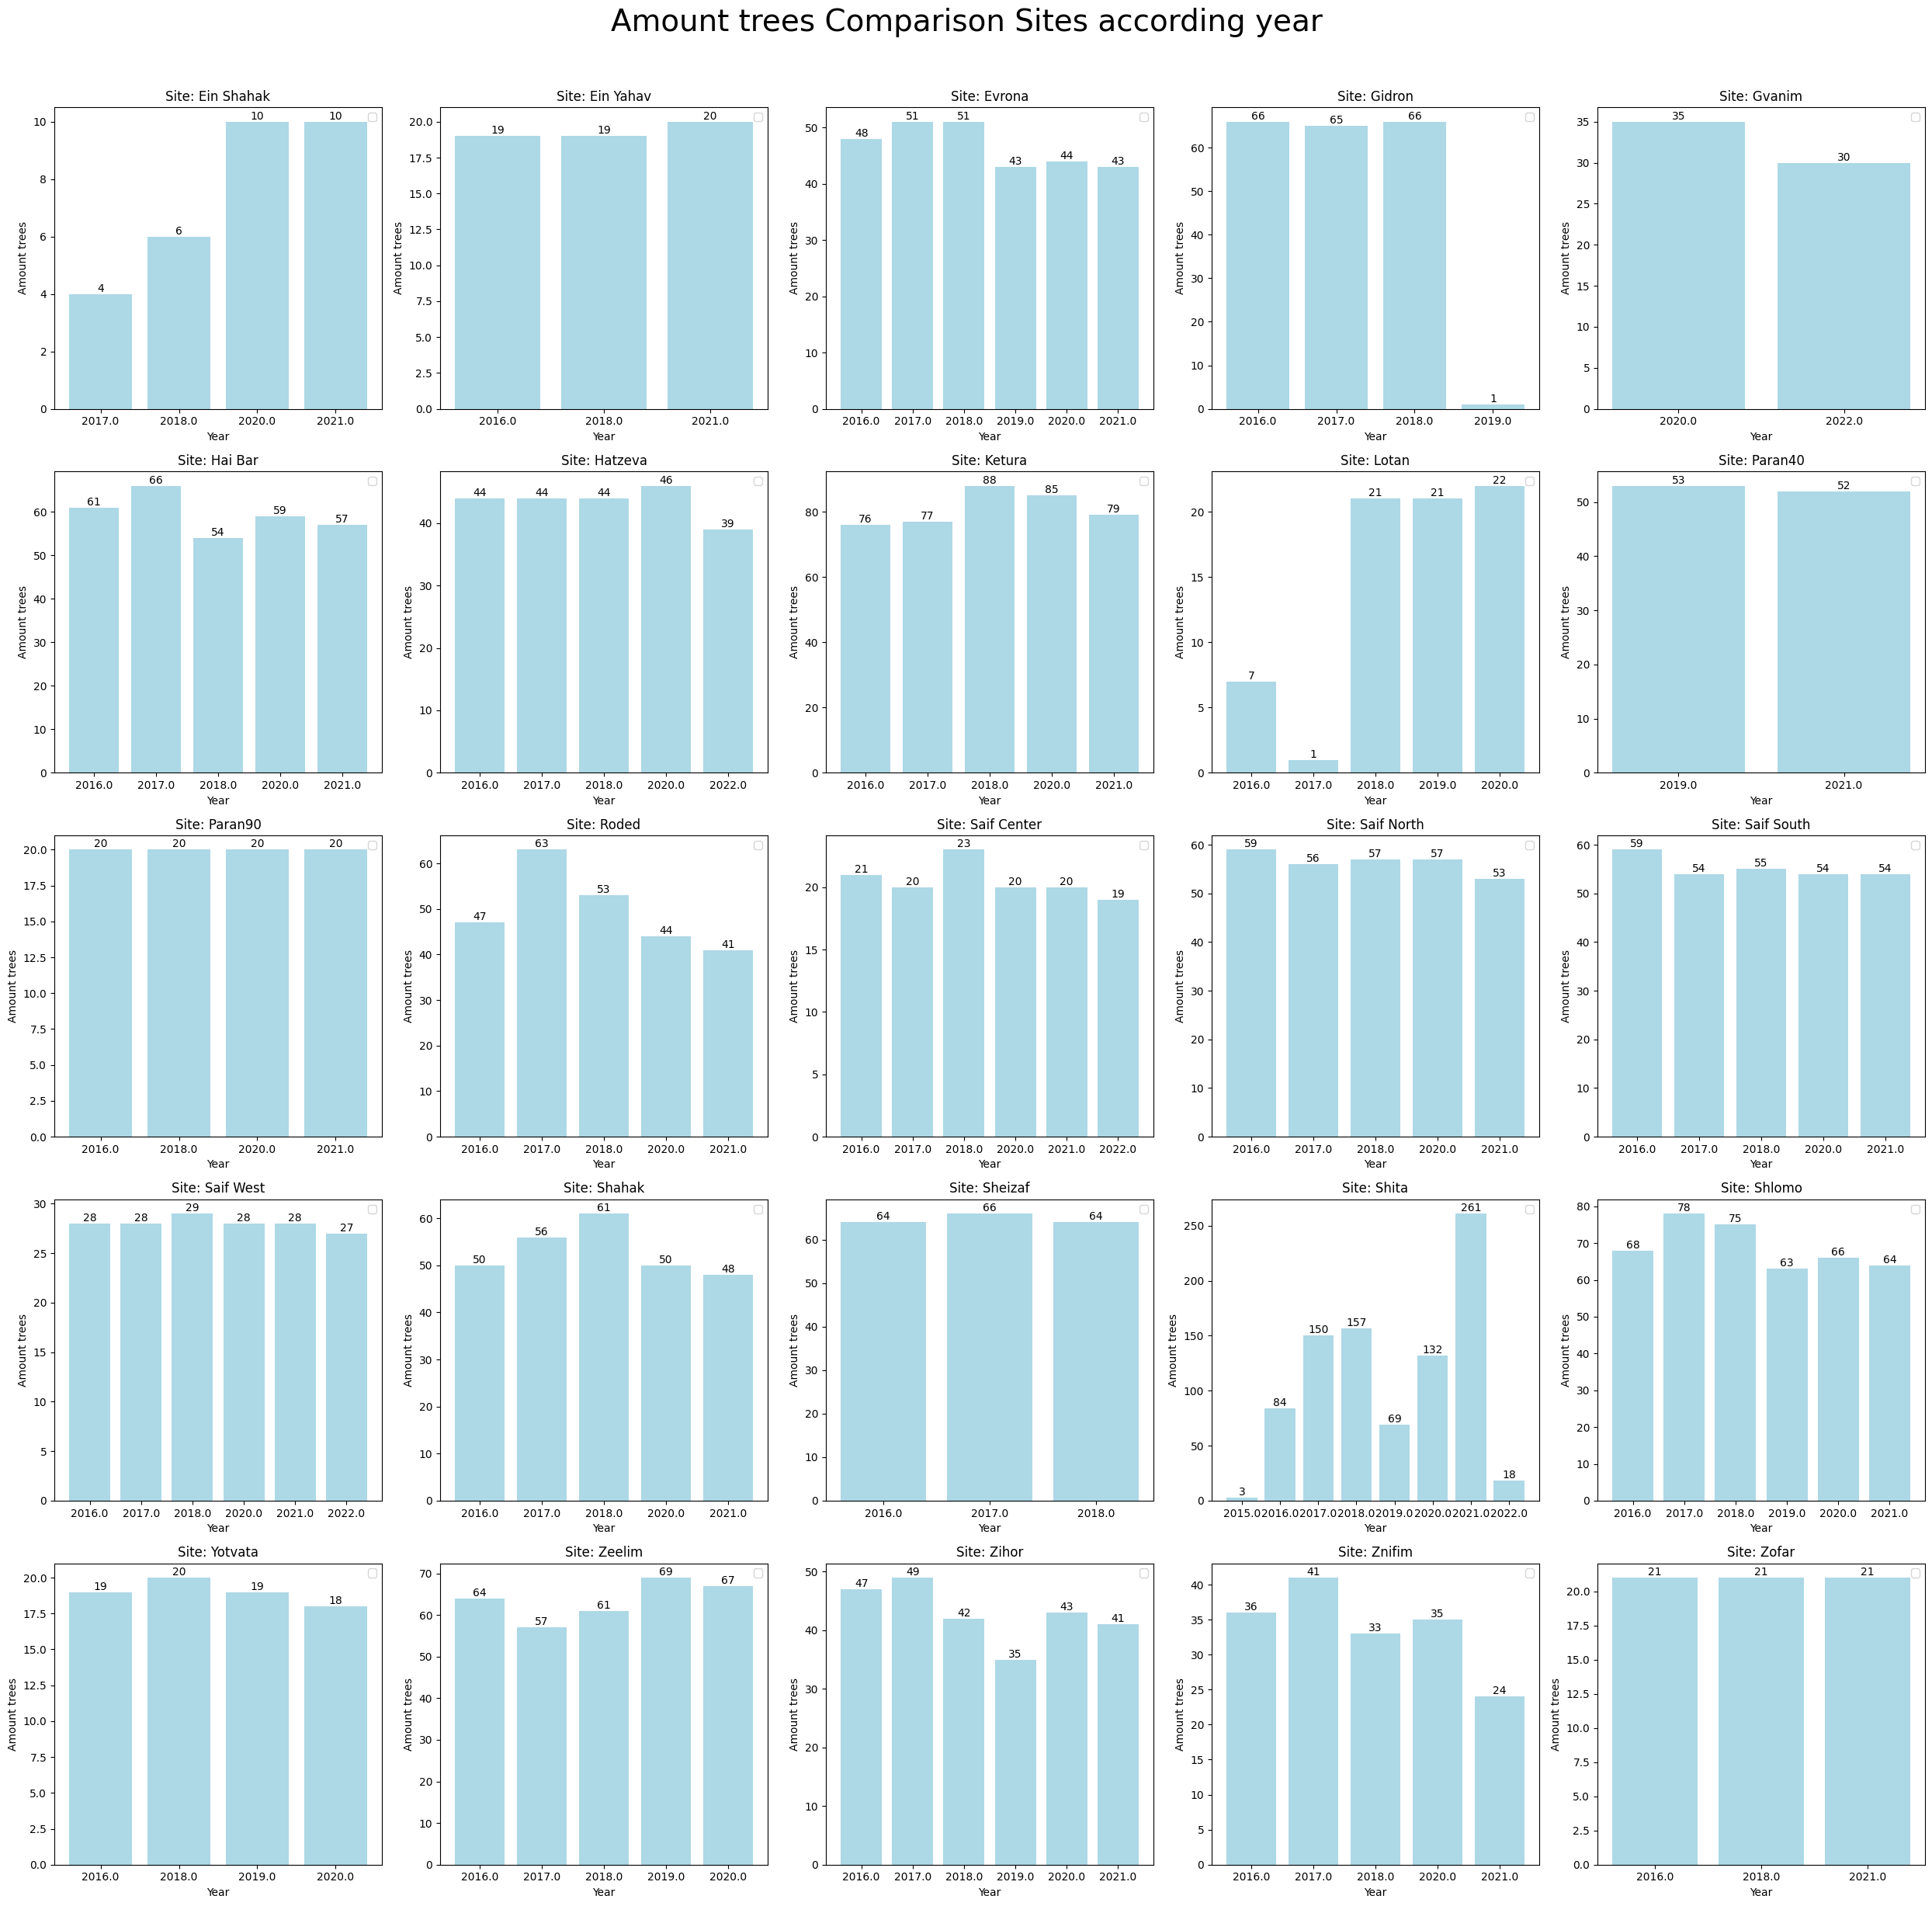

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def create_plot_trees(data, site, subplot_index):
    plt.subplot(5, 5, subplot_index)

    data_site = data[data['site_new'] == site]
    data_site['year'] = data_site['year'].astype(str)
    data_all = data_site.groupby('year')['tree_id'].nunique().reset_index(name='count')
    years = data_all['year'].values
    values = data_all['count'].values
    plt.bar(years, values, color='lightblue')

    # Add text above each bar
    for i in range(len(years)):
        plt.text(years[i], values[i], f'{values[i]}', ha='center', va='bottom')

    plt.xlabel('Year')
    plt.ylabel('Amount trees')
    plt.title(f'Site: {site}')

    plt.legend()


plt.figure(figsize=(25, 25))

subplot_index = 1
for site in list_new_site:
    create_plot_trees(merged_df_year, site, subplot_index)
    subplot_index += 1

plt.suptitle('Amount trees Comparison Sites according year\n\n', size=28)
plt.tight_layout()

plt.show()


## Foliage average

In [ ]:
import plotly.express as px

def plot_avg_column_by(title,x_title,y_title,data,colum_g1,colum_g2,colum_by):
  data = data[data[colum_by]<999]

  data = data[data[colum_by]>0]

  # Assuming you have the DataFrame merged_df_stream with 'site_new', 'foliage', and 'stream' columns
  grouped_mean = data.groupby(['tree_id',colum_g1,colum_g2])[colum_by].mean()

  # Calculate the average 'foliage' values for each 'site_new' and 'stream' combination
  average = grouped_mean.groupby([colum_g1,colum_g2]).mean().reset_index()

  # Create the bar plot
  fig = px.bar(average, x=colum_g1, y=colum_by, color=colum_g2, barmode='group')

  fig.update_layout(title=title, xaxis_title=x_title, yaxis_title=y_title)

  fig.show()



def plot_sum_column_by(title, x_title, y_title, data, colum_g1, colum_by):
    data = data[data[colum_by]<999]

    grouped_mean = data.groupby(['tree_id',colum_g1])[colum_by].mean()

    # Calculate the sum of 'colum_g2' values for each 'colum_g1', 'colum_g3', and year combination
    summed_data = grouped_mean.groupby([colum_g1]).mean().reset_index()
    # Create the line plot
    summed_data = summed_data[summed_data[colum_by]>0]

    fig = px.bar(summed_data, x=colum_g1, y=colum_by, color=colum_g1)

    fig.update_layout(title=title, xaxis_title=x_title, yaxis_title=y_title)

    fig.show()


In [ ]:
merged_df_stream = merged_df[merged_df['stream'].isin(['Secondary', 'Main'])]

In [ ]:
plot_sum_column_by('Average Foliage by Site','Site New','Average Foliage',merged_df_stream,'site_new','foliage')

In [ ]:
plot_avg_column_by('Average Foliage by Site New and Stream','Site New','Average Foliage',merged_df_stream,'site_new','stream','foliage')

## Height average

In [ ]:
plot_sum_column_by('Average height by Site New and Stream','Site New','Average height',merged_df_stream,'site_new','height')

In [ ]:
plot_avg_column_by('Average height by Site New and Stream','Site New','Average height',merged_df_stream,'site_new','stream','height')

## Pelicosepalus average

In [ ]:
plot_sum_column_by('Average pelicosepalus acaciae by sites','Site New','Average pelicosepalus acaciae',merged_df_stream,'site_new','pelicosepalus_acaciae')

In [ ]:
plot_avg_column_by('Average pelicosepalus acaciae by sites according stream','Site New','Average pelicosepalus acaciae',merged_df_stream,'site_new','stream',  'pelicosepalus_acaciae')

## Perimeter

In [ ]:
merged_df_perimeter_cm = merged_df_year.dropna(subset=['perimeter_cm'])

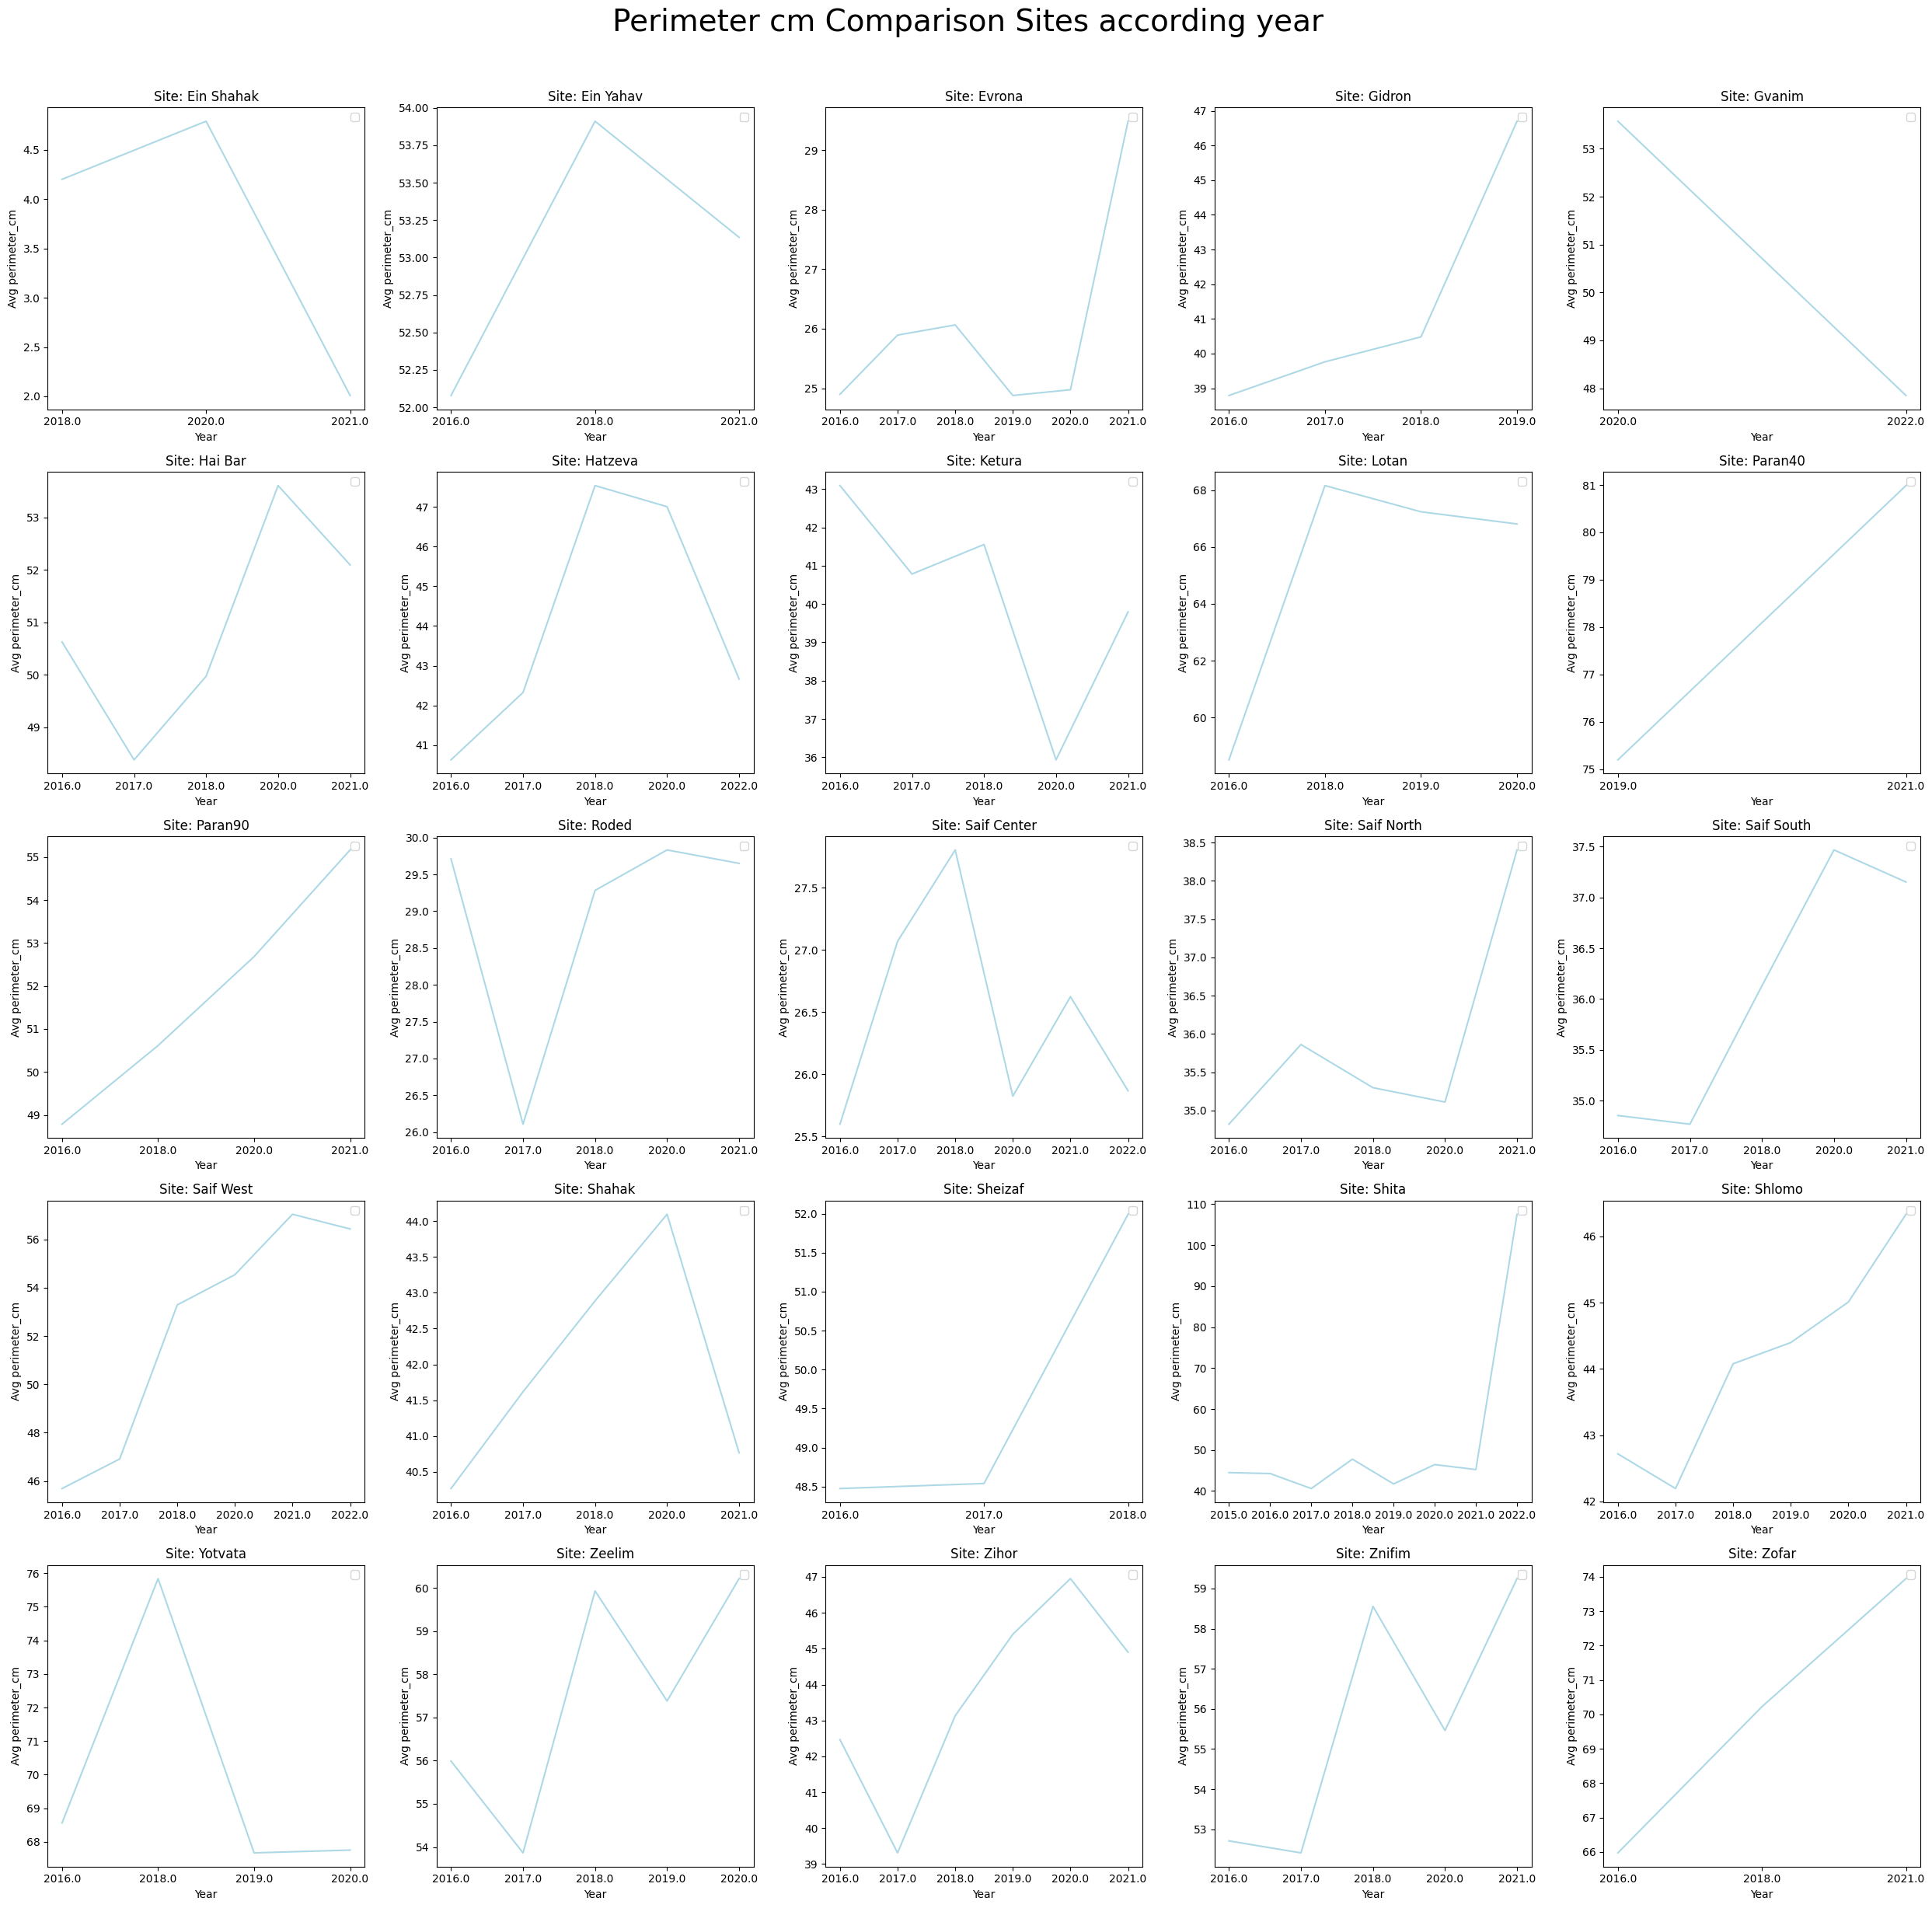

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def create_plot_perimeter(data,site,subplot_index):
    plt.subplot(5, 5, subplot_index)

    data_site = data[data['site_new'] == site]
    data_site['year'] = data_site['year'].astype(str)
    grouped_mean = data_site.groupby(['tree_id','year'])['perimeter_cm'].mean()

    data_site_year = grouped_mean.groupby(['year']).mean()

    years = data_site_year.index
    values = data_site_year.values
    plt.plot(years,values, color='lightblue')

    plt.xlabel('Year')
    plt.ylabel('Avg perimeter_cm')
    plt.title(f'Site: {site}')

    plt.legend()



plt.figure(figsize=(25, 25))

subplot_index = 1
for site in list_new_site:
    create_plot_perimeter(merged_df_perimeter_cm, site,subplot_index)
    subplot_index += 1


plt.suptitle('Perimeter cm Comparison Sites according year\n\n',size=28)
plt.tight_layout()

plt.show()

##Trees Species by site

In [ ]:
merged_df_species = merged_df.dropna(subset=['species'])
merged_df_species = merged_df_species[merged_df_species['species'] != 'Dead']
g_df_species= merged_df_species.groupby(['site_new', 'species']).size().reset_index(name='count')

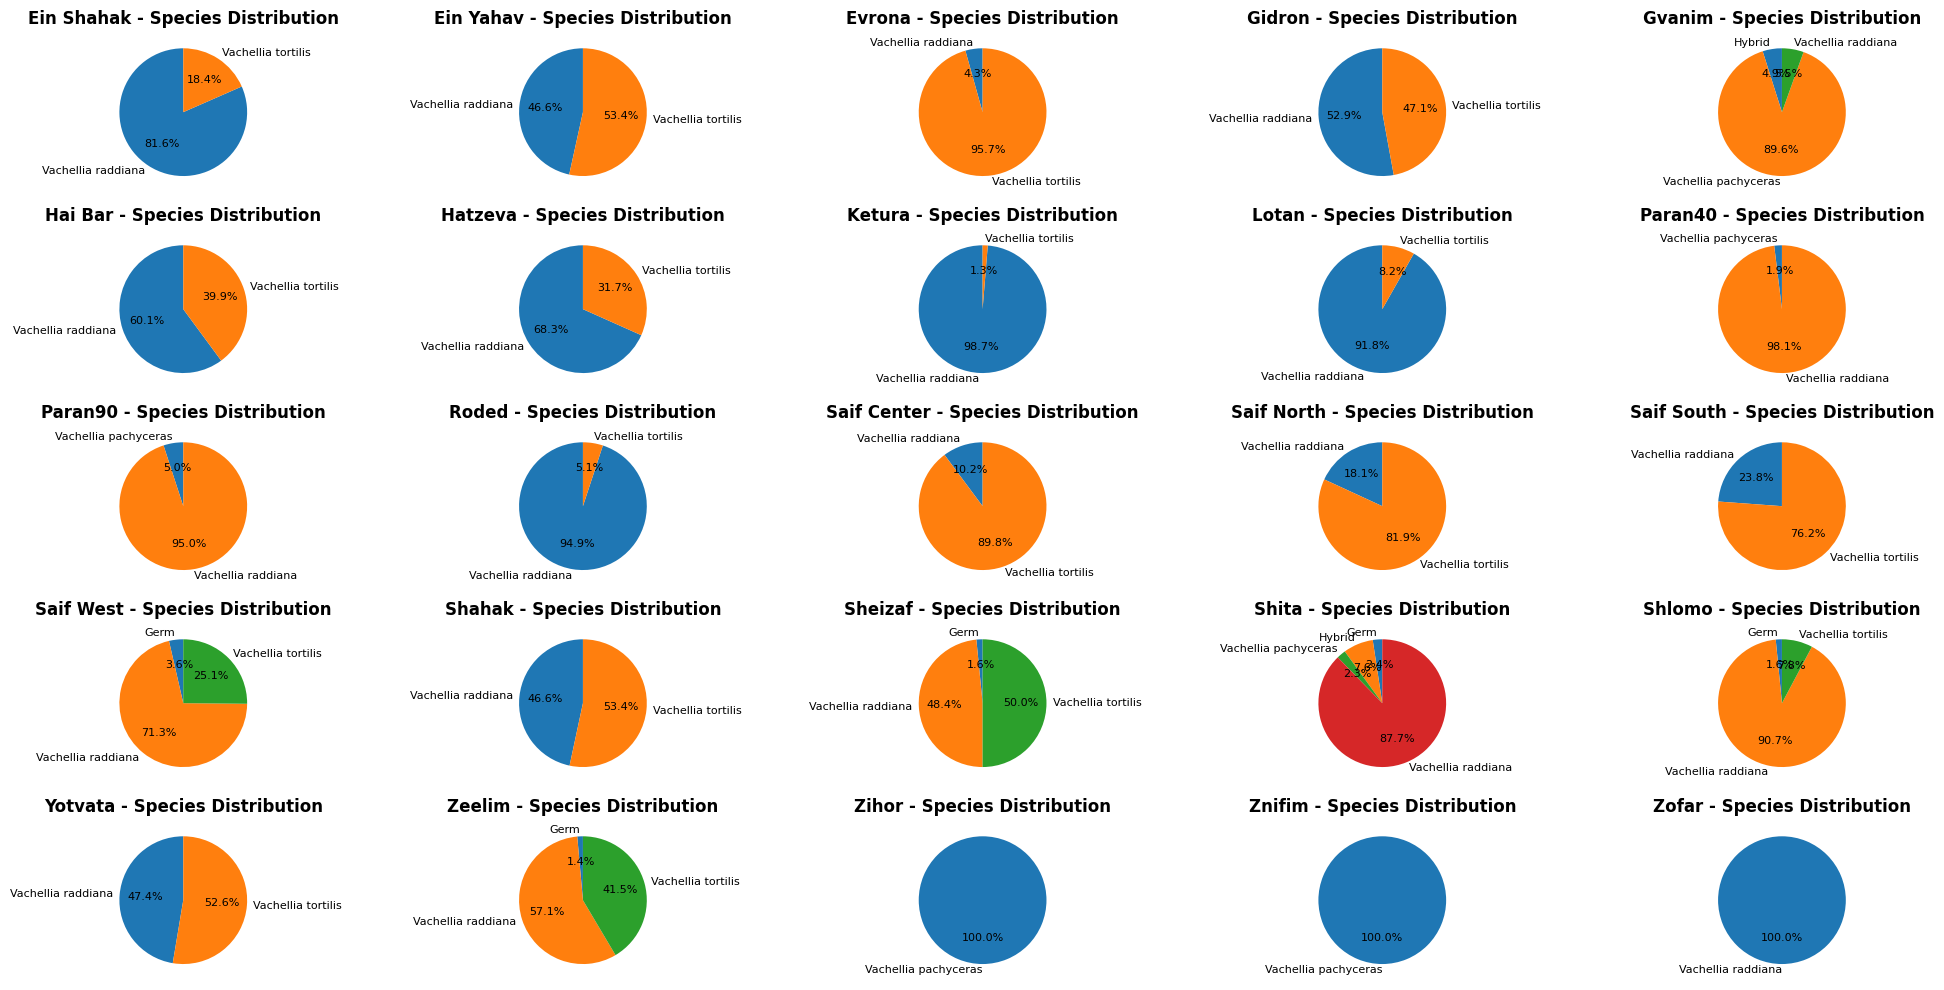

In [ ]:
# Get unique sites
unique_sites = g_df_species['site_new'].unique()

# Create subplots for pie charts
num_sites = len(unique_sites)
num_rows = (num_sites+1)//5
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))

# Flatten the 2D array of subplots for easier iteration
axes = axes.flatten()
# Loop through unique sites and create pie charts
for i, site in enumerate(unique_sites):
  ax = axes[i]
  by_site_df = g_df_species[g_df_species['site_new'] == site]
  # species_counts = site_df.groupby('species')['count'].sum()
  ax.pie(by_site_df['count'], labels=by_site_df['species'], autopct='%1.1f%%', startangle=90,textprops={'fontsize': 8})
  ax.set_title(f'{site} - Species Distribution', fontweight='bold')

# Hide any unused subplots
for i in range(len(unique_sites), num_rows * num_cols):
    axes[i].axis('off')

# Adjust layout and display the plot
plt.tight_layout()

plt.show()

##Trees Status by site

In [ ]:
merged_df_year = merged_df.dropna(subset=['year'])
merged_df_status = merged_df_year[merged_df_year['current_status'].isin(['Alive', 'Dead','Dry'])]

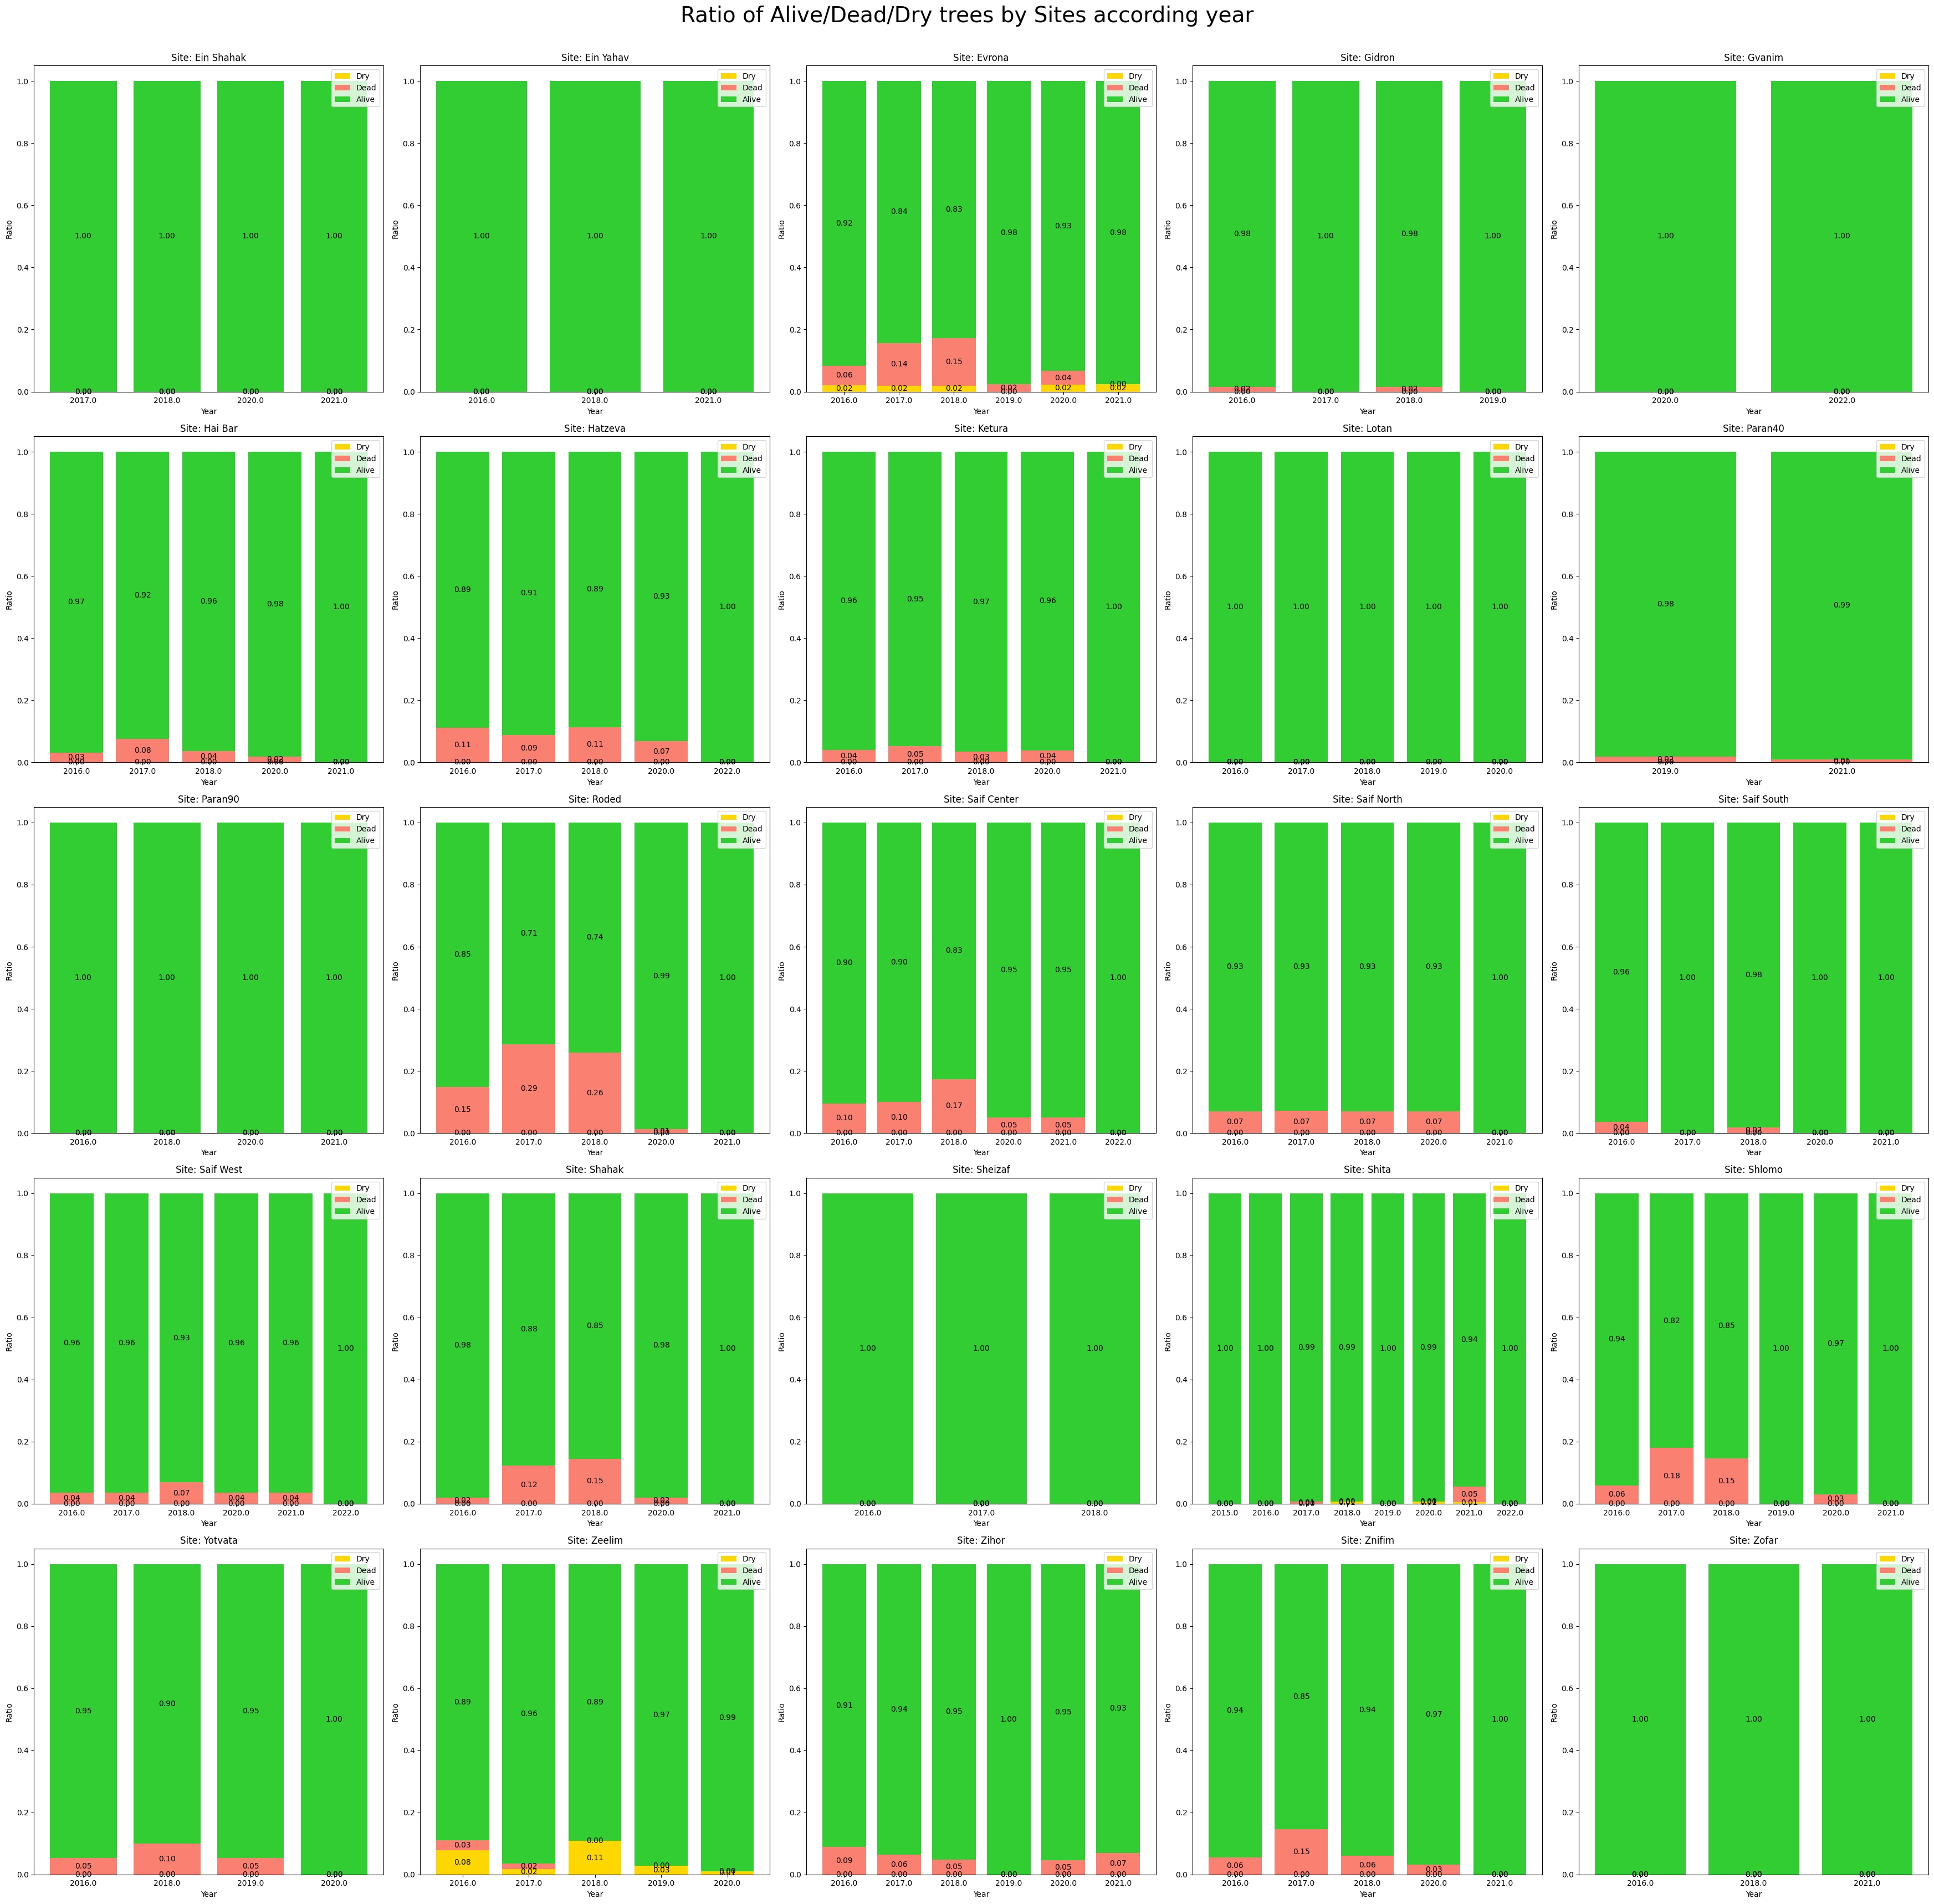

In [ ]:
def create_plot_Alive(data, site, subplot_index):
    plt.subplot(5, 5, subplot_index)

    data_site = data[data['site_new'] == site]
    data_site['year'] = data_site['year'].astype(str)
    data_all = data_site.groupby(['year']).size().reset_index(name='count_all')
    data_Alive = data_site[data_site['current_status'] == 'Alive']
    data_Alive = data_Alive.groupby(['year']).size().reset_index(name='count_alive')
    data_Dead = data_site[data_site['current_status'] == 'Dead']
    data_Dead = data_Dead.groupby(['year']).size().reset_index(name='count_dead')
    data_Dry = data_site[data_site['current_status'] == 'Dry']
    data_Dry = data_Dry.groupby(['year']).size().reset_index(name='count_dry')

    # Merge all the data
    merged_df = pd.merge(data_all, data_Alive, on='year', how='left')
    merged_df = pd.merge(merged_df, data_Dead, on='year', how='left')
    merged_df = pd.merge(merged_df, data_Dry, on='year', how='left')

    # Fill NaN values with 0
    merged_df.fillna(0, inplace=True)

    years = merged_df['year'].values
    alive_ratio = merged_df['count_alive'] / merged_df['count_all']
    dead_ratio = merged_df['count_dead'] / merged_df['count_all']
    dry_ratio = merged_df['count_dry'] / merged_df['count_all']

    # Calculate the 'Other' ratio
    other_ratio = 1 - (alive_ratio + dead_ratio + dry_ratio)

    # Plot the bars in the desired order
    plt.bar(years, dry_ratio, color='gold', label='Dry')
    plt.bar(years, dead_ratio, bottom=dry_ratio, color='salmon', label='Dead')
    plt.bar(years, alive_ratio, bottom=dry_ratio + dead_ratio, color='limegreen', label='Alive')

    # Add text above each bar
    for i in range(len(years)):
        plt.text(years[i], dry_ratio[i] / 2, f'{dry_ratio[i]:.2f}', ha='center', va='center', color='black')
        plt.text(years[i], dry_ratio[i] + dead_ratio[i] / 2, f'{dead_ratio[i]:.2f}', ha='center', va='center', color='black')
        plt.text(years[i], dry_ratio[i] + dead_ratio[i] + alive_ratio[i] / 2, f'{alive_ratio[i]:.2f}', ha='center', va='center', color='black')

    plt.xlabel('Year')
    plt.ylabel('Ratio')
    plt.title(f'Site: {site}')
    plt.legend()


plt.figure(figsize=(35, 35))

subplot_index = 1
for site in list_new_site:
    create_plot_Alive(merged_df_status, site, subplot_index)
    subplot_index += 1

plt.suptitle('Ratio of Alive/Dead/Dry trees by Sites according year\n\n', size=28)
plt.tight_layout()

plt.show()


## Foliage Distribution

In [ ]:
def map_foliage_to_labels(value):
    if value <= 1:
        return "Low"
    elif  value <= 3:
        return "Medium"
    else:
        return "High"


merged_df_new_foliage = merged_df.dropna(subset=['foliage'])
merged_df_new_foliage["new_foliage"] = merged_df_new_foliage["foliage"].apply(map_foliage_to_labels)
g_df_foliage= merged_df_new_foliage.groupby(['site_new', 'new_foliage']).size().reset_index(name='count')

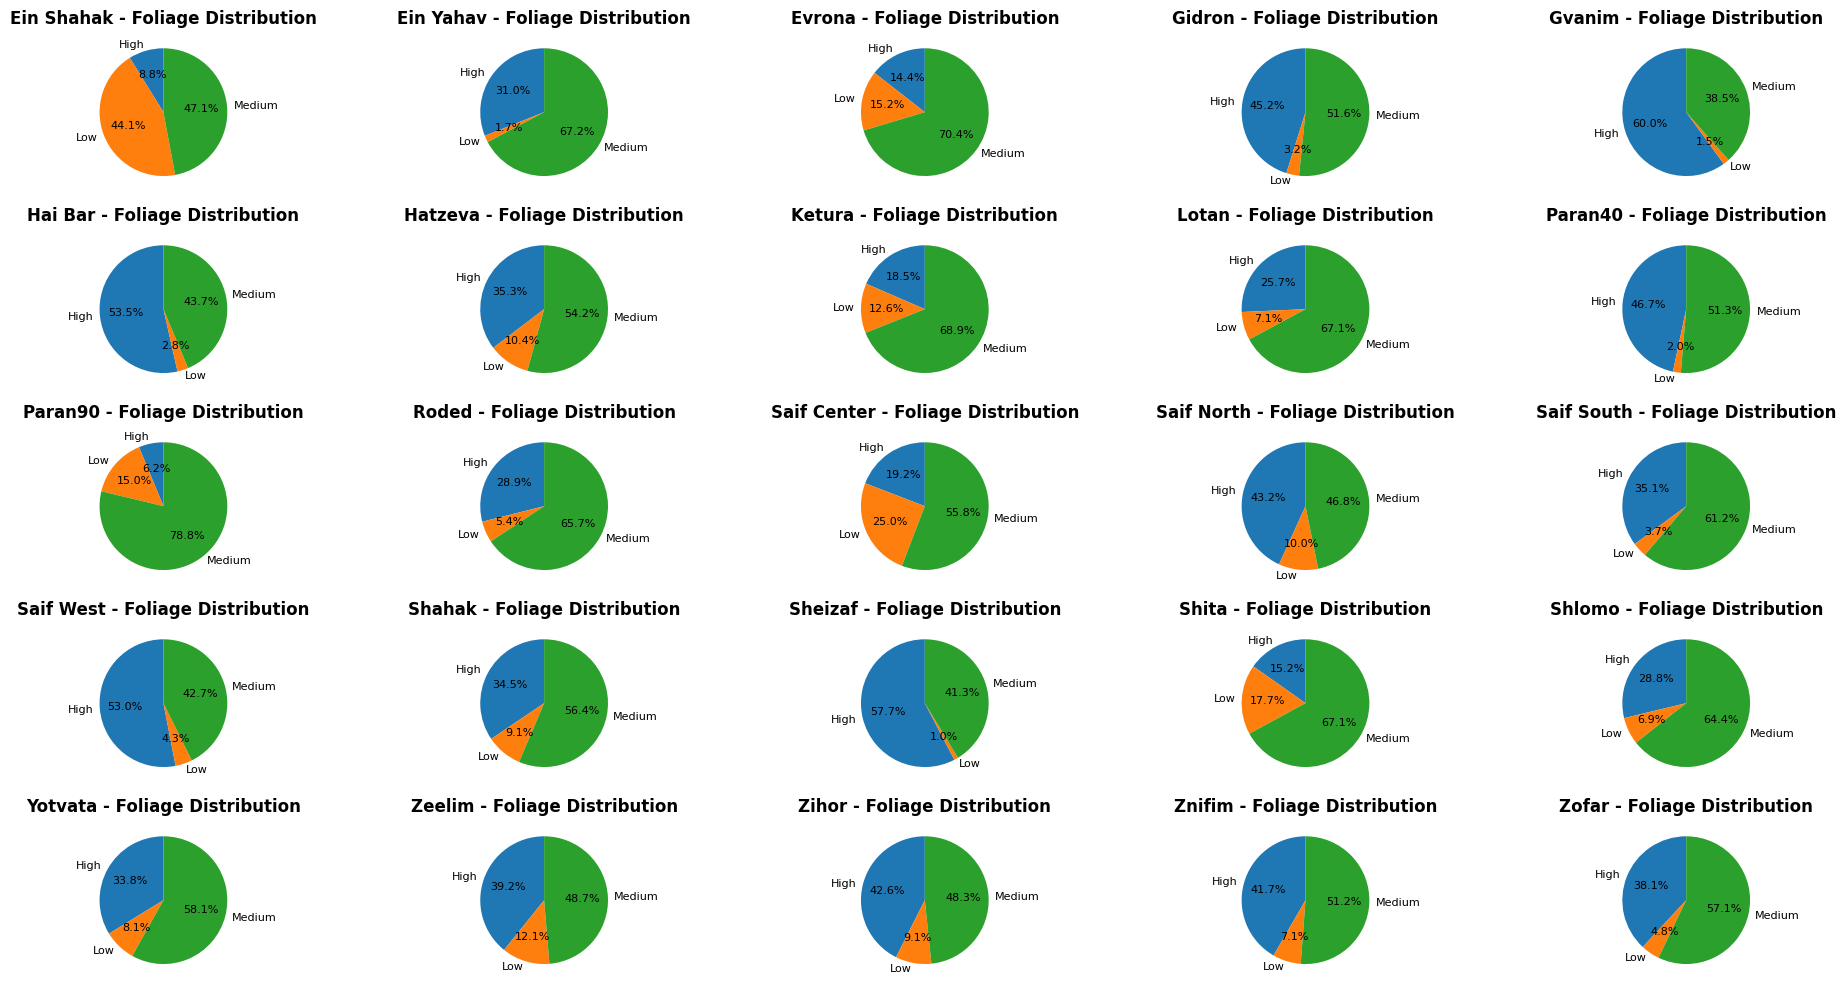

In [ ]:
# Get unique sites
unique_sites = g_df_foliage['site_new'].unique()

# Create subplots for pie charts
num_sites = len(unique_sites)
num_rows = (num_sites+1)//5
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 10))

# Flatten the 2D array of subplots for easier iteration
axes = axes.flatten()
# Loop through unique sites and create pie charts
for i, site in enumerate(unique_sites):
  ax = axes[i]
  by_site_df = g_df_foliage[g_df_foliage['site_new'] == site]
  # species_counts = site_df.groupby('species')['count'].sum()
  ax.pie(by_site_df['count'], labels=by_site_df['new_foliage'], autopct='%1.1f%%', startangle=90,textprops={'fontsize': 8})
  ax.set_title(f'{site} - Foliage Distribution', fontweight='bold')

# Hide any unused subplots
for i in range(len(unique_sites), num_rows * num_cols):
    axes[i].axis('off')

# Adjust layout and display the plot
plt.tight_layout()

plt.savefig('Foliage Site.png')

plt.show()

# Model

In [ ]:
model_df = merged_df.drop(columns=['_record_id','_geometry','monitors','stream','stream_val','height','canopy_e_w_cm','date','month','day','Plot_MG','_latitude',	'_longitude'])

In [ ]:
# Sort the DataFrame by name and year
model_df = model_df.sort_values(by=['site_new', 'tree_id'])
# Calculate the last year's value and create a new column 'new_val'
model_df['Target'] = model_df.groupby(['site_new', 'tree_id'])['foliage'].shift(-1)
model_df.rename(columns={'foliage': 'curr_foliage'}, inplace=True)


# Function to map age values to labels
def map_foliage_to_labels(value):
    if value <= 1:
        return "Low"
    elif  value <= 3:
        return "Medium"
    else:
        return "High"

model_df = model_df.dropna()
model_df["Target"] = model_df["Target"].apply(map_foliage_to_labels)

model_df = pd.get_dummies(model_df, columns=['site_new', 'species', 'current_status'])
model_df = model_df.drop(columns=['tree_id','year','Loranthus acaciae','infected trees'])
model_df = model_df[model_df['browsing_height_s']<999]

In [ ]:
model_df['Target'].value_counts()

Medium    848
High      559
Low       154
Name: Target, dtype: int64

In [ ]:
X=model_df.drop(columns=['Target'])
y=model_df['Target']
# Initialize MinMaxScaler
scaler = MinMaxScaler()
# Apply normalization to the specified columns
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# Initialize and train classifier models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=86),
    'Gradient Boosting': GradientBoostingClassifier(random_state=3),
    'Support Vector Classifier': SVC(random_state=3),
    'K-Nearest Neighbors': KNeighborsClassifier()
}
results = []

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results.append({
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1
    })

# Display the results with adjusted font size and rounded values
results_df = pd.DataFrame(results, index=models.keys())
styled_df = results_df.style.format({'Accuracy': '{:.3f}', 'Recall': '{:.3f}', 'Precision': '{:.3f}', 'F1 Score': '{:.3f}'})
styled_df.set_table_styles([{'selector': '', 'props': [('font-size', '16px')]}])
display(styled_df)

,Accuracy,Recall,Precision,F1 Score
Decision Tree,0.623,0.623,0.626,0.624
Random Forest,0.725,0.725,0.725,0.721
Gradient Boosting,0.690,0.690,0.686,0.679
Support Vector Classifier,0.687,0.687,0.703,0.659
K-Nearest Neighbors,0.642,0.642,0.639,0.640


## Feature selection

In [ ]:
model = RandomForestClassifier(random_state=86)
model.fit(X_train, y_train)
# Get feature importances and sort them
feature_importances = model.feature_importances_
sorted_indices = feature_importances.argsort()[::-1]

# Get the top 3 feature names and their importances
top_feature_names = X_train.columns[sorted_indices[:3]]
top_feature_importances = feature_importances[sorted_indices[:3]]

# Print top feature names and importances
for feature, importance in zip(top_feature_names, top_feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: perimeter_cm, Importance: 0.2917
Feature: browsing_height_s, Importance: 0.1985
Feature: curr_foliage, Importance: 0.1512


## Shap

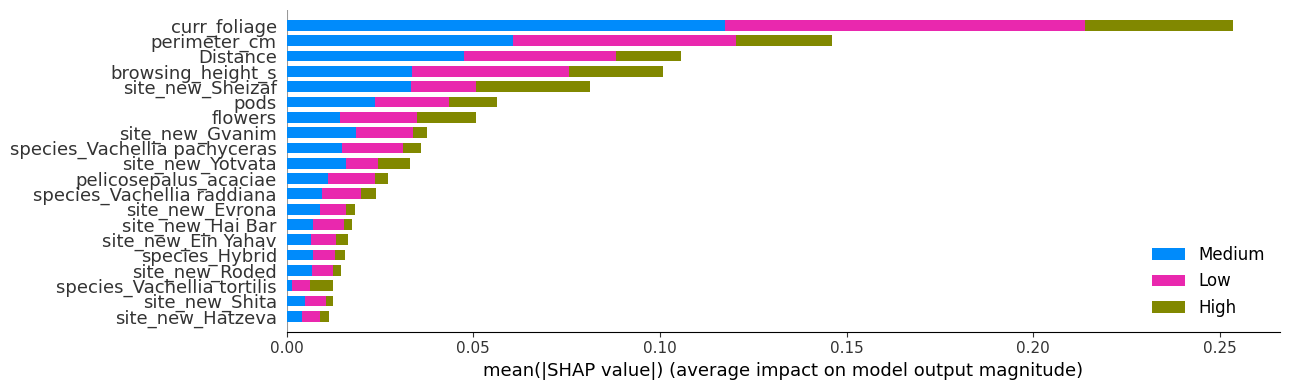

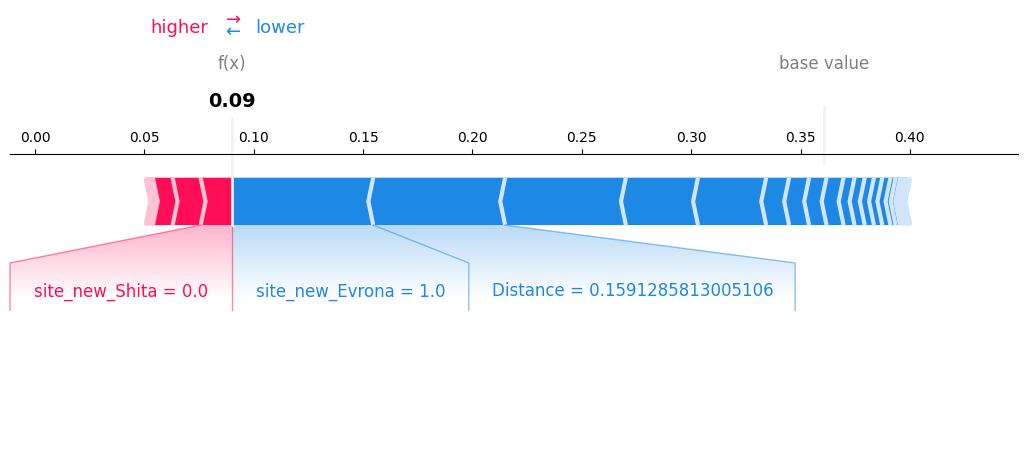

In [ ]:
feature_names = model_df.columns
# Initialize a SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
class_names=['Medium','High','Low']
# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train, feature_names=feature_names,class_names=class_names, plot_size=(13, 4))

# Visualize individual SHAP values for a specific instance
instance_index = 0  # Index of the instance you want to visualize
shap.force_plot(explainer.expected_value[0], shap_values[0][instance_index], X_train.iloc[instance_index], matplotlib=True, figsize=(13, 4))

plt.show()